# Comparing Original LeetCode Solutions to Online Solutions

Leetcode is an ubiquitous platform used by those in the tech industry to prepare for data structures and algorithms problems that may arise during the interview process. In this notebook, we compare a dataset of originally developed Leetcode solutions (solved by myself over the span of a few years) to a dataset of solutions scraped from a set of leetcode.com forum pages, where one forum page is dedicated to each problem. The analysis is done using a series of techniques from Natural Language Processing. An list of the analyses we perform is below:

(Under development)

Ultimately, the goal of this project is to discover my strengths and weaknesses (with regards to data structures and algorithms, but also coding more generally) with a data driven methodology and use these to identify personal development areas.

## Part I: Scraping dataset of online solutions

Leetcode is a dynamic website built using React. For this reason, lightweight scrapers such as requests + beautifulsoup would not suffice. Instead, we use Selenium to scrape our database of solutions. The architecture we will consider for scraping can be conceptualized as a tree of depth 3. 

Root node: leetcode.com

Depth 1: Href to every problem on leetcode.com (~2500 children)

Depth 2: Href to every post on the forums for the given problem (~60 children per node)

Depth 3: Code posted in each original post on the forums (1 child per node)

We will scrape the tree using breadth first search. i.e. scraping will be done in stages, each stage corresponding to a further depth.

1. Scrape a list of all problems and slugs so that we may crawl individual problem pages.
2. For each problem, scrape the links of the top 4 pages of posts with the 'python3' tag on the Solutions forum.
3. Scrape the text for all post links scraped in step 2.

In [383]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException, WebDriverException

from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import re
import os

# Dark mode plotting
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)


pd.set_option('display.max_colwidth', None)

dataset_path = 'dataset'
original_solutions_path = 'problem_solutions'

In [3]:
def get_premium_info(el):
        '''
        Searches a specific div element given as argument for an orange svg object, which indicates the bounding box for the leetcode premium lock symbol on the left of a problem.
        This svg is only present for premium problems.
        '''
        try:
            el.find_element(By.CLASS_NAME, 'text-brand-orange')
        except NoSuchElementException:
            return False
        return True
    
def scrape_problems_list(num_pages= 50, problems_per_page=50):
    '''
    Scrapes master list of problems on leetcode in order to get a dataset of hyperlinks (or equivalently, slugs) to the page dedicated to each individual problem.
    '''
    problems_dict = defaultdict(list)
    for i in range(num_pages):
        print(f"Page: {i+1}")
        source_page = f'https://leetcode.com/problemset/all/?page={i+1}'
        driver = webdriver.Chrome()
        driver.get(source_page)
        time.sleep(60) if (i and not i % 10) else time.sleep(5) # Allow page to load without implicitly_wait (because we check for premium by checking for exception)
        all_rows = driver.find_element(By.XPATH, '//*[@id="__next"]/div/div[2]/div[1]/div[1]/div[6]/div[2]/div/div/div[2]')
        j = 0
        while j < problems_per_page:
            try:
                problem_row = all_rows.find_element(By.XPATH, f'./div[{j + 1}]')
                elements = problem_row.find_elements(By.CLASS_NAME, 'mx-2')
                problems_dict['premium'].append(get_premium_info(elements[0]))
                problems_dict['href'].append(elements[1].find_element(By.XPATH, './/div/div/div/div/a').get_attribute('href'))
                problems_dict['title'].append(elements[1].find_element(By.XPATH, './/div/div/div/div/a').text)
                problems_dict['acceptance'].append(elements[3].find_element(By.XPATH, './/span').text)
                problems_dict['difficulty'].append(elements[4].find_element(By.XPATH, './/span').text)
            except NoSuchElementException:
                print(f'Fewer than {problems_per_page} problems on this page.')
            j += 1
    return pd.DataFrame(problems_dict)

def scrape_solutions_forum(problem_slug, num_pages=4):
    '''
    Scrapes the solutions forum dedicated to a given problem (specified via problem slug) in order get a dataset of hyperlinks to the top 60 posts (by votes) with the 'python3' tag for that problem.
    '''
    post_dict = defaultdict(list)
    for i in range(1, num_pages + 1):
        source_page = f'https://leetcode.com/problems/{problem_slug}/discuss/?currentPage={i}&orderBy=most_votes&query=&tag=python3'
        driver = webdriver.Chrome()
        driver.get(source_page)
        driver.implicitly_wait(5) # Allow page to load before throwing exception
        current_page_posts = driver.find_elements(By.CLASS_NAME, 'topic-item-wrap__2FSZ')
        for post in current_page_posts:
            href = post.find_element(By.XPATH, './/*[@class="topic-item__1Asc"]/div[1]/div[1]/a').get_attribute('href')
            title = post.find_element(By.XPATH, './/*[@class="topic-item__1Asc"]/div[1]/div[1]/a/div/div').text
            try:
                user = post.find_element(By.XPATH, './/*[@class="topic-item__1Asc"]/div[1]/div[2]/span/span[1]/a').text
            except NoSuchElementException:
                user = 'deleted_user'
            upvotes = post.find_element(By.XPATH, './/*[@class="topic-item__1Asc"]/div[2]/div[1]/div').text
            views = post.find_element(By.XPATH, './/*[@class="topic-item__1Asc"]/div[2]/div[2]/div').text
            post_dict['slug'].append(problem_slug)
            post_dict['title'].append(title)
            post_dict['user'].append(user)
            post_dict['upvotes'].append(upvotes)
            post_dict['views'].append(views)
            post_dict['href'].append(href)    
        time.sleep(2)
    return pd.DataFrame(post_dict)

def parse_html_to_python(html_code_block):
    lines = html_code_block.split('\n')
    solution_flag = True
    python_flag = True
    if '<span class="hljs-class">' not in lines[0]:
        solution_flag = False
    res = [re.sub('</span>', '', re.sub('<span class="hljs-[\s\S]*?">', '', line)) for line in lines] # for code formatting / coloring
    res = [re.sub('&gt;', '>', re.sub('&lt;', '<', line)) for line in res] # HTML entities
    res = '\n'.join(res)
    # Some posts contain solutions for multiple languages. This is a nifty way to check for python solutions, 
    # since every solution defines a function and no other language requires "(self," in function declarations within a class.
    if '(self,' not in res:
        python_flag = False
    return solution_flag and python_flag, res

def parse_html_to_python_2(html_code_block):
    lines = html_code_block.split('\n')
    solution_flag = True
    python_flag = True
    if 'Solution' not in lines[0]:
        solution_flag = False
    res = [re.sub('</span>', '', re.sub('<span[\s\S]*?>', '', line)) for line in lines] # for code formatting / coloring
    res = [re.sub('&gt;', '>', re.sub('&lt;', '<', line)) for line in res] # HTML entities
    res = '\n'.join(res)
    # Some posts contain solutions for multiple languages. This is a nifty way to check for python solutions, 
    # since every solution defines a function and no other language requires "(self," in function declarations within a class.
    if '(self,' not in res:
        python_flag = False
    return solution_flag and python_flag, res

def scrape_single_post(post_href):
    '''
    Scrapes a single post to return the text written in the original post. Comments are ignored.
    '''
    driver = webdriver.Chrome()
    driver.get(post_href)
    driver.implicitly_wait(5)
    original_post_body = driver.find_elements(By.XPATH, '//*[@id="discuss-container"]/div/div/div[2]/div[1]/div[2]/div[2]/div')#[0]
    try:
        code_blocks = original_post_body.find_elements(By.XPATH, './/pre') # <pre> </pre> used for code formatting
    except NoSuchElementException:
        pass # No code blocks in the original post
    all_solutions_in_post = []
    for block in code_blocks:
        html = block.find_element(By.XPATH, './/code').get_attribute('innerHTML')
        valid_solution, parsed_html = parse_html_to_python(html)
        if valid_solution:
            all_solutions_in_post.append(parsed_html)
    return all_solutions_in_post

def scrape_single_post_2(post_href):
    '''
    Scrapes a single post to return the text written in the original post. Comments are ignored.
    '''
    driver = webdriver.Chrome()
    driver.get(post_href)
    driver.implicitly_wait(5)
    original_post_body = driver.find_elements(By.CLASS_NAME, 'break-words')[0]
    try:
        code_blocks = original_post_body.find_elements(By.XPATH, './/div/div/div/div/pre') # <pre> </pre> used for code formatting
    except NoSuchElementException:
        pass # No code blocks in the original post
    all_solutions_in_post = []
    for block in code_blocks:
        html = block.find_element(By.XPATH, './/code').get_attribute('innerHTML')
        valid_solution, parsed_html = parse_html_to_python_2(html)
        if valid_solution:
            all_solutions_in_post.append(parsed_html)
    return all_solutions_in_post

Scrape problems list and preprocess for a list of all problem names, slugs, numbers, acceptance rates, and difficulties. 

In [40]:
#problems_df = scrape_problems_list() # Uncomment to rescrape data
#problems_df.to_csv(f'{dataset_path}/problems_data.csv')
problems_df = pd.read_csv(f'{dataset_path}/problems_data.csv', index_col='Unnamed: 0')
problems_df['number'] = problems_df['title'].str.split('.').map(lambda x: x[0]).astype('int64')
problems_df['title_text'] = problems_df['title'].str.split('.').map(lambda x: x[1]).str[1:]
problems_df['slug'] = problems_df['href'].str.split('/').map(lambda x: x[-2])
problems_df['acceptance'] = problems_df['acceptance'].str[:-1].astype('float64') / 100. # Convert percentage to decimal

problems_df.drop_duplicates(inplace=True) # The featured problem will always be duplicated (once at top of list, once in proper numeric ordering)
problems_df.loc[problems_df['premium'] == 0] # Unable to scrape paid problems.
problems_df = problems_df[['title_text', 'slug', 'number', 'acceptance', 'difficulty']].sort_values('number').reset_index(drop=True)
problems_df.to_csv(f'{dataset_path}/problems_data_cleaned.csv')

Loop over problem slugs, saving the first 4 pages of posts (order by most views) with the 'python3' tag. 

In [ ]:
problems_df = pd.read_csv(f'{dataset_path}/problems_data_cleaned.csv', index_col='Unnamed: 0')
all_posts_hrefs = []
for i, slug in enumerate(problems_df['slug']):
    df_of_post_hrefs = scrape_solutions_forum(slug)
    all_posts_hrefs.append(df_of_post_hrefs)
    if i and not i % 10:
        temp_save_df = pd.concat(all_posts_hrefs, axis=0)
        temp_save_df.to_csv(f'{dataset_path}/post_hrefs/intermediate_post_hrefs_df_{i}.csv')
        time.sleep(60)
    else:
        time.sleep(5)
all_posts_hrefs_df = pd.concat(all_posts_hrefs, axis=0)
all_posts_hrefs_df.to_csv(f'{dataset_path}/all_posts_hrefs.csv')

Loop over scraped post hrefs, save any python solutions in the original post of each thread.

In [4]:
all_posts_hrefs_df = pd.read_csv(f'{dataset_path}/all_posts_hrefs.csv', index_col=0)
#all_solutions = []
#concat_solutions = pd.DataFrame({'post_href': [], 'python_solutions': []})
restart_i = 30500
concat_solutions = pd.read_csv(f'{dataset_path}/post_solutions/intermediate_post_solutions_df_{restart_i}.csv')
all_solutions = [concat_solutions]
for i, href in enumerate(all_posts_hrefs_df['href']):
    if i > restart_i:
        try:
            python_solutions = scrape_single_post_2(href)
        except WebDriverException:
            python_solutions = []
        except IndexError:
            python_solutions = []
            print(f'Excepted IndexError at index: {i}')
        all_solutions.append(pd.DataFrame({'post_href': href, 'python_solutions': python_solutions}))
        concat_solutions = pd.concat(all_solutions, axis=0).reset_index(drop=True)
        if i and not i % 100:
            concat_solutions.to_csv(f'{dataset_path}/post_solutions/intermediate_post_solutions_df_{i}.csv')
            all_solutions = [concat_solutions]
            time.sleep(30)
        else:
            time.sleep(3)
concat_solutions.to_csv(f'{dataset_path}/all_posts_solutions.csv')

Excepted IndexError at index: 31566
Excepted IndexError at index: 31567
Excepted IndexError at index: 31718
Excepted IndexError at index: 31732
Excepted IndexError at index: 32467
Excepted IndexError at index: 33768
Excepted IndexError at index: 33884
Excepted IndexError at index: 34199
Excepted IndexError at index: 34877
Excepted IndexError at index: 37418
Excepted IndexError at index: 38274
Excepted IndexError at index: 40902
Excepted IndexError at index: 41346
Excepted IndexError at index: 43482
Excepted IndexError at index: 44760
Excepted IndexError at index: 50276
Excepted IndexError at index: 50450
Excepted IndexError at index: 50651


__Retrospective__: The fortunate thing about web scraping is that it only needs to work once to have a usable dataset, no matter how scrappy the solution is. The downside is that its inefficient (for both the DS and the website owner) to retroactively apply any learnings that may have been found during the process; they're only best applied going forward on different projects. 

The issue with scraping the site in a breadth first manner as was done is that, each time a new chrome window is launched, a small set of files is written to /tmp. Since this dataset required launching a window for each page, the /tmp file on the VM would fill up the hard drive and crash the notebook. This doesn't occur too often, but happened at least 3 or 4 times over the course of the run.

The easiest solution would likely be to move the <code> driver = webdriver.Chrome() </code> so that it is defined within the scope of the for loop and does not relaunch the window when going from page to page. More complicated solutions would be to use a different browser that does not write out such large temporary files on launch. A last solution would be to use a depth first search of the tree, where a single window starts at root and crawls down to each leaf. This would be able to back out and go to the next leaf in the same window.

Another unexpected issue was that the frontend of the website updated halfway through scraping the dataset, changing the XPath of the elements that I were grabbed from each post. This is why there are 2 versions of the function for scraping a single post; 1 is pre update and 1 is post update. If frontend updates like this are common, it is very possible that somebody attempting to rerun this code will run into issues relating to incorrect XPaths.

## Part 2: General ETL

#### Scraped dataset

Combine individual csv files into a single pandas DataFrame containing all information relevant to a solution.

In [581]:
problem_info = pd.read_csv(f'{dataset_path}/problems_data_cleaned.csv', index_col=0) # Depth 1
post_info = pd.read_csv(f'{dataset_path}/all_posts_hrefs.csv', index_col=0).reset_index() # Depth 2
post_solutions = pd.read_csv(f'{dataset_path}/all_posts_solutions.csv')[['post_href', 'python_solutions']] # Depth 3

# Merge DFs to a single DF
posts = post_solutions.merge(post_info, how='inner', left_on='post_href', right_on ='href').drop(['index', 'href'], axis=1, inplace=False)
posts = posts.merge(problem_info, how = 'inner', on='slug').rename({'title_text': 'problem_title', 'title':'post_title'}, axis=1)
# Fix problem titles
posts['problem_title'] = posts['problem_title'].str.lower()
posts['problem_title'] = [re.sub("'", '', re.sub("\s?-\s?", ' ', re.sub("\?", '', re.sub("%", ' percent', title)))) for title in posts['problem_title']]
# Convert strings to floats
posts['views'] = posts['views'].str.replace('K', 'e+03').astype('float').astype('int')
posts['upvotes'] = posts['upvotes'].str.replace('K', 'e+03').astype('float').astype('int')

#### Original Solutions Dataset

Create DataFrame from the directory of original solutions

In [582]:
dict_of_original_solutions = {difficulty: os.listdir(f'{original_solutions_path}/{difficulty}') for difficulty in ['easy', 'medium', 'hard']}

original_solutions_dict = {'file_name': [], 'problem_name': [], 'original_solution': [], 'ext': []}
for difficulty, files in dict_of_original_solutions.items():
    for file_name in files:
        problem_name = re.sub('_',' ', file_name.split('.')[0].lower())
        with open(f'{original_solutions_path}/{difficulty}/{file_name}') as f:
            content = f.read()
            content = re.sub("'''[\s\S]*?'''", '', content) # Remove comments at the top of the file.
            content = content[1:] if content[0] == '\n' else content # Remove new line at the beginning of the solution.
            original_solutions_dict['file_name'].append(file_name)
            original_solutions_dict['ext'].append(file_name.split('.')[-1])
            original_solutions_dict['problem_name'].append(problem_name)
            original_solutions_dict['original_solution'].append(content)
original_solutions_df = pd.DataFrame(original_solutions_dict)
original_solutions_df = original_solutions_df[original_solutions_df['ext'] == 'py'] # Only python solutions for now
# It seems like our scraping session missed some problems. Here we filter the original dataset to the set of problems that we've scraped solutions for.
print(f'Number of problems before filter: {original_solutions_df.shape[0]}')
original_solutions_df = original_solutions_df[original_solutions_df['problem_name'].isin(posts['problem_title'].unique())]
print(f'Number of problems after filter: {original_solutions_df.shape[0]}')

Number of problems before filter: 484
Number of problems after filter: 456


In [583]:
problem_weights = posts.value_counts('problem_title').to_frame().reset_index().rename({0: 'weight'}, axis=1)
original_solutions_df = original_solutions_df.merge(problem_weights, how = 'left', left_on = 'problem_name', right_on = 'problem_title').drop('problem_title', axis=1)
online_solutions_df = posts[posts['problem_title'].isin(original_solutions_df['problem_name'])]

## Part 3: EDA

Since this dataset is entirely new to me, we run some EDA for quality control and to get a better understanding of what the data looks like. Additionally, there is a few hypotheses that I am interested in investigating in this section. For the sake of notebook cleanliness, basic EDA with large text outputs has been removed.

### Number of solutions per problem

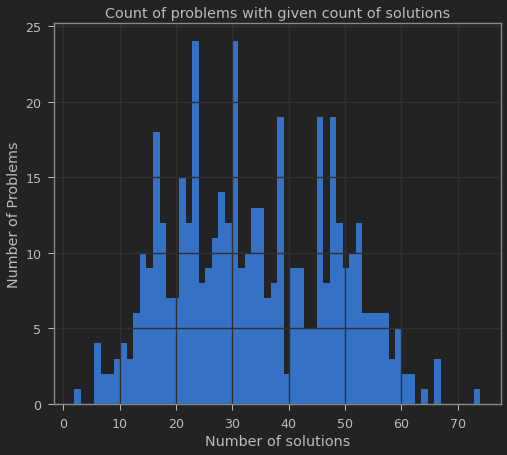

In [338]:
original_solutions_df.hist(column = 'weight', bins = original_solutions_df['weight'].unique().shape[0])
plt.xlabel('Number of solutions')
plt.ylabel("Number of Problems")
plt.title('Count of problems with given count of solutions')
plt.show()

### User Statistics

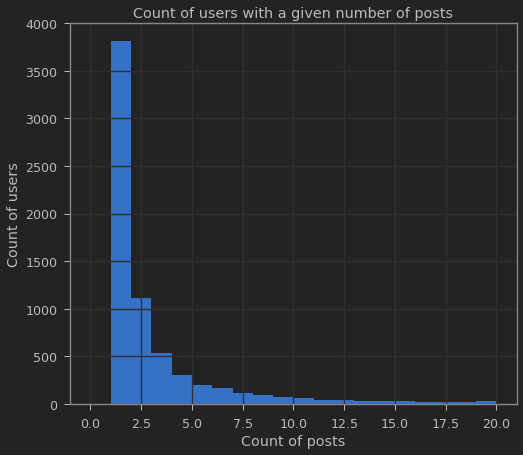

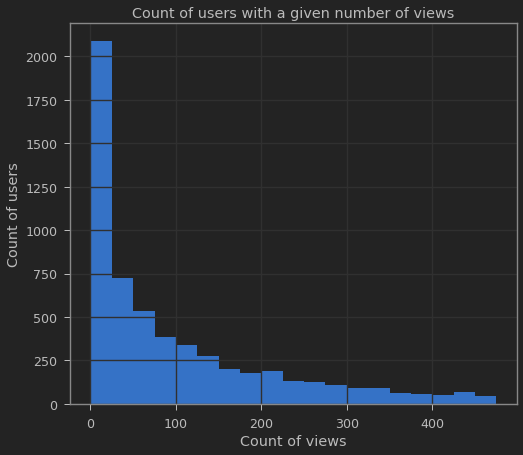

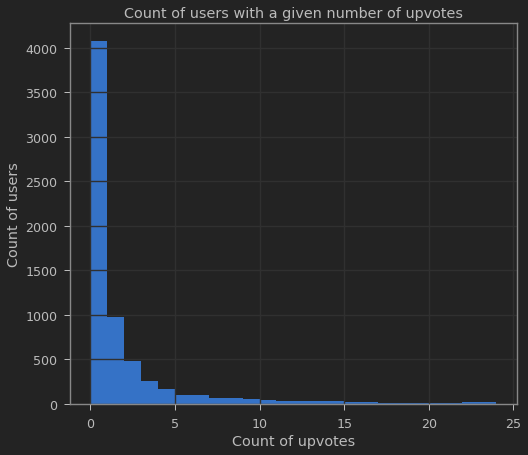

In [544]:
user_post_count = posts.groupby('user').agg({'post_href': 'count', 'views': 'sum', 'upvotes': 'sum'})
user_post_count.hist(column = 'post_href', bins=range(21))
plt.xlabel('Count of posts')
plt.ylabel("Count of users")
plt.title('Count of users with a given number of posts')
plt.show()

user_post_count.hist(column = 'views', bins=range(0, 500, 25))
plt.xlabel('Count of views')
plt.ylabel("Count of users")
plt.title('Count of users with a given number of views')
plt.show()

user_post_count.hist(column = 'upvotes', bins=range(25))
plt.xlabel('Count of upvotes')
plt.ylabel("Count of users")
plt.title('Count of users with a given number of upvotes')
plt.show()

In [545]:
user_post_count.sort_values('post_href', ascending=False).head(20)

,post_href,views,upvotes
user,,,
ye15,1962,624252,7677
domthedeveloper,416,51372,379
junaidmansuri,377,427240,2778
EklavyaJoshi,372,37116,328
dereky4,350,51008,229
Taha-C,310,27912,106
maosipov11,300,15821,49
EvgenySH,271,25203,72
sanial2001,256,31357,119


All metrics show that the majority of users only post a handful of times, with a handful of power users account for a disproportionate number of posts / upvotes / views. We can calculate the Gini coefficient, typically used in economics as a measure of income inequality, to quantify the inequality between users.

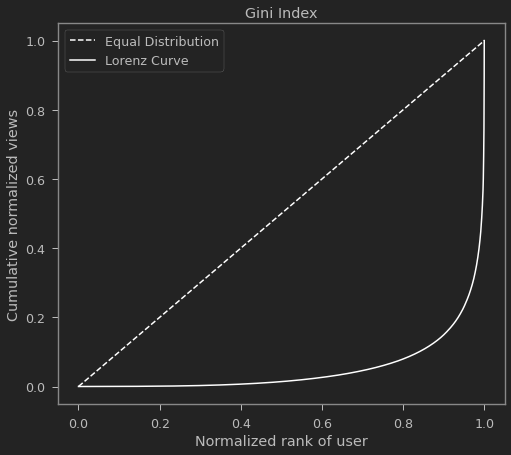

Gini Coefficient: 0.8977


In [546]:
lorenz_curve = user_post_count.sort_values('views', ascending=True).reset_index()
lorenz_curve['normalized_views'] = lorenz_curve['views'] / lorenz_curve['views'].sum()
lorenz_curve['normalized_cumulative_views'] = lorenz_curve['normalized_views'].cumsum()
lorenz_curve['normalized_ranks'] = lorenz_curve.index / lorenz_curve.shape[0]
plt.plot([0.0, 1.0], [0.0,1.0], color = 'w', linestyle='--', label='Equal Distribution')
plt.plot(lorenz_curve['normalized_ranks'].values, lorenz_curve['normalized_cumulative_views'].values, color = 'w', label='Lorenz Curve')
plt.xlabel('Normalized rank of user')
plt.ylabel('Cumulative normalized views')
plt.legend()
plt.title('Gini Index')
plt.show()
# Measure of inequality that is between 0 and 1: (area between dashed and solid) / (area under dashed).
print(f"Gini Coefficient: {1 - np.trapz(lorenz_curve['normalized_cumulative_views'].values, x=lorenz_curve['normalized_ranks'].values) / .5:.4f}")

A Gini index of 0.8977 is a *very* unequal distribution

### Simple and Easy Solutions

It's very common for people to label their solution as simple or easy. Does this have an effect on the reach of the solution?

Fraction simple or easy: 0.3627


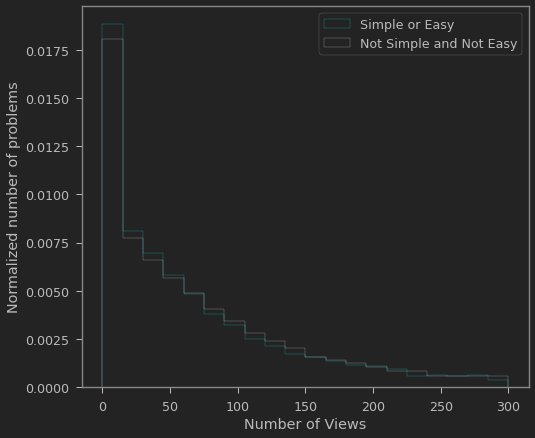

In [547]:
simple_easy_flag = posts['post_title'].str.lower().str.contains('simple') | posts['post_title'].str.lower().str.contains('easy')
print(f'Fraction simple or easy: {simple_easy_flag.sum() / simple_easy_flag.shape[0]:.4f}')
simple_easy_bins = np.linspace(0, 300, 21)
plt.hist(posts.loc[simple_easy_flag]['views'].values, bins=simple_easy_bins, color='cyan', histtype='step', density=True, label='Simple or Easy')
plt.hist(posts.loc[~simple_easy_flag]['views'].values, bins=simple_easy_bins, color = 'w', histtype='step', density=True, label='Not Simple and Not Easy')
plt.xlabel('Number of Views')
plt.ylabel('Normalized number of problems')
plt.legend()
plt.show()
# No difference at all after normalization

### Dependence of views on acceptance rate

The hypothesis is that people will refer to the solutions more for difficult problems (with lower acceptance rate) than for harder problems (with higher acceptance rate)

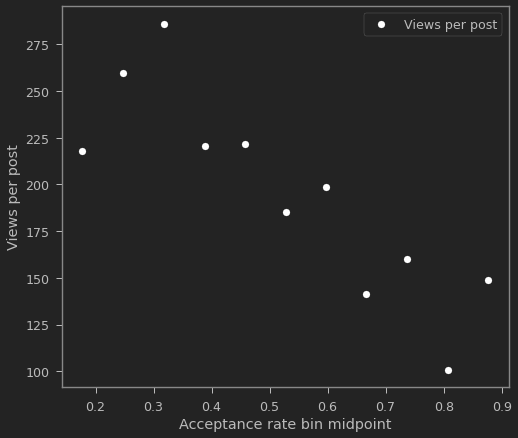

In [548]:
acceptance_eda = posts.copy()
acceptance_eda['acceptance_bin'] = pd.cut(acceptance_eda['acceptance'], bins=11)
acceptance_eda['acceptance_bin'] = [(interval.left + interval.right) / 2 for interval in acceptance_eda['acceptance_bin']]

acceptance_binned = acceptance_eda.groupby('acceptance_bin').agg({'post_href': 'count', 'views':'sum', 'slug': pd.Series.nunique}).reset_index()
acceptance_binned['views_per_post'] = acceptance_binned['views'] / acceptance_binned['post_href']
plt.scatter(acceptance_binned['acceptance_bin'].values, acceptance_binned['views_per_post'].values, color='w', label='Views per post')
plt.xlabel('Acceptance rate bin midpoint')
plt.ylabel('Views per post')
plt.legend()
plt.show()

The hypothesis does seem to hold true, posts on problems with lower acceptance rate tend to get more views.
Further testing would be needed to determine whether this is a causal relationship or just a correlation.
It could just be that there are more solutions / problems with higher acceptance rate, which suppresses the per post average (see cell below).

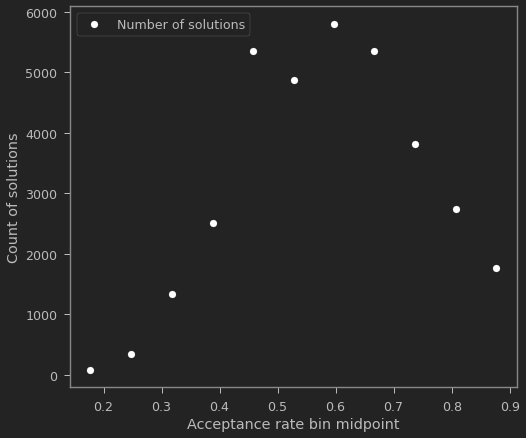

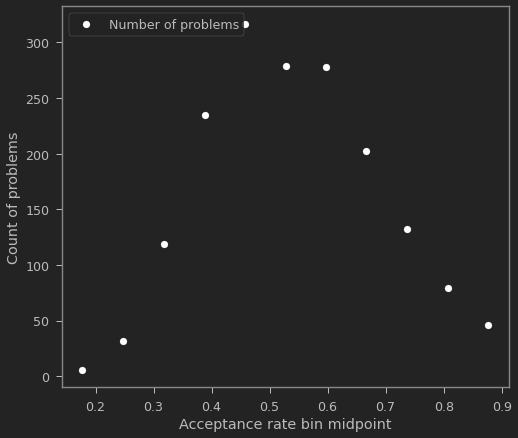

In [549]:
plt.scatter(acceptance_binned['acceptance_bin'].values, acceptance_binned['post_href'].values, color='w', label='Number of solutions')
plt.xlabel('Acceptance rate bin midpoint')
plt.ylabel('Count of solutions')
plt.legend(loc='upper left')
plt.show()

plt.scatter(acceptance_binned['acceptance_bin'].values, acceptance_binned['slug'].values, color='w', label='Number of problems')
plt.xlabel('Acceptance rate bin midpoint')
plt.ylabel('Count of problems')
plt.legend(loc='upper left')
plt.show()

I'm curious what the above plot looks like when broken out among difficulty levels.

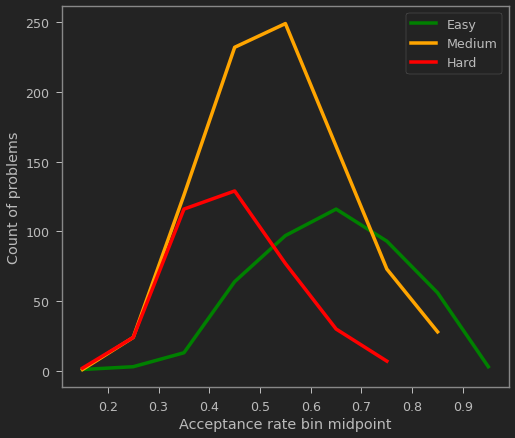

In [552]:
posts_eda = posts.copy()
posts_eda['acceptance_bin'] = pd.cut(posts_eda['acceptance'], bins=np.linspace(0, 1, 11))
posts_eda['acceptance_bin'] = [(interval.left + interval.right) / 2 for interval in posts_eda['acceptance_bin']]

posts_binned = posts_eda.groupby(['acceptance_bin', 'difficulty']).agg({'post_href': 'count', 'views':'sum', 'slug': pd.Series.nunique}).reset_index()
for difficulty, color in zip(['Easy', 'Medium', 'Hard'], ['green', 'orange', 'red']):
    plt.plot(posts_binned[posts_binned['difficulty'] == difficulty]['acceptance_bin'].values, posts_binned[posts_binned['difficulty'] == difficulty]['slug'].values, color=color, label=difficulty, linewidth=3.5)
plt.xlabel('Acceptance rate bin midpoint')
plt.ylabel('Count of problems')
plt.legend(loc='upper right')
plt.show()
# Predictably, acceptance rate decreases as difficulty increases.

### Upvote to view ratio

I am manually inspecting the solutions with the highest upvote to view ratio, as I suspect that these will be the highest quality solutions in the dataset (since users most strongly felt the need to upvote after viewing these problems). A minimum cutoff is applied to the number of views to avoid issues with low statistics.

In [499]:
min_views = 50
upv_view_ratio_eda = online_solutions_df.copy()
upv_view_ratio_eda['ratio'] = upv_view_ratio_eda['upvotes'] / upv_view_ratio_eda['views']
upv_view_ratio_eda = upv_view_ratio_eda.sort_values('ratio', ascending=False)
upv_view_ratio_eda = upv_view_ratio_eda[upv_view_ratio_eda['views'] >= min_views]
for sol in upv_view_ratio_eda['python_solutions'].head(20):
    print(sol)

class Solution:
    def lowestCommonAncestor(self, root: 'TreeNode', p: 'TreeNode', q: 'TreeNode') -> 'TreeNode':
        if p is None or q is None:
            return None
        if root == p or root == q:
            return root
        if (root.left == p and root.right ==q) or (root.right == p and root.left == q):
            return root
        if p.val < root.val and q.val < root.val:
            return self.lowestCommonAncestor(root.left, p, q)
        elif p.val > root.val and q.val > root.val:
            return self.lowestCommonAncestor(root.right, p, q)
        
        return root
class Solution:
    def nextGreatestLetter(self, letters: List[str], target: str) -> str:

        t_ord = ord(target) - ord('a')
        for i in letters:
            l_ord = ord(i) - ord('a')
            if l_ord > t_ord:
                return i
        return letters[0] # if no chrater is gte that target then return 0 index element
class Solution:
    def isPerfectSquare(self, num: int) -> boo

## Part 4: Preliminary Analysis

In this section I begin to compare the datasets of solutions. I specifically analyze the following:

    1. Simple count of control flow keywords
    2. Count of more complex syntax patterns (comprehensions)
    3. 'conventional' measures of code / solution quality: Length, spacing, indentation, and changes in indentation
    
Bag of words usually makes for a good first try when beginning an NLP problem. However, python is not a natural language, and this introduces some additional factors which should be considered before naively beginning a bag of words type analysis. First, variable names have nearly no syntax regulations regarding their naming. As such, a bag of words model will contain numerous variable names that are never repeated. Second, there are very strong syntax rules regarding a very limited set of keywords and patterns. (in progress)

In [704]:
def get_term_frequency_from_solutions_df(df, problem_col, code_col):
    df['weight'] = df['weight'] if 'weight' in df.columns else 1
    code_df = df[['weight', problem_col, code_col]].reset_index(drop=True)
    keywords = [' if ', ' for ', 'elif', ' def ', 'while', 'return', ' try ', 'except', 'else', 'with', ' is ', ' in ', ' and ', ' or ', ' not ', ' as ', 'lambda', 'break', 'continue', 'pass', '\+', '-', '=', '==', '\*', '/', '\n', '\t', '\+=', '::']
    other_terms = ['Counter\(', '.append\(', 'int', 'float', '-1', 'range\(', 'len\(', '.add', 'self.', 'sorted\(', '.sort\(\)', 'zip\(', 'enumerate\(', '\#', 'max\(', 'min\(']
    regexs = {'list_comprehension_count': '\[.* for .* in .*\]', 'set_comprehension_count': '{.* for .* in .*}', 'dict_comprehension_count': '{.*:.* for .* in .*}', 'generator_comprehension_count': '\(.*:.* for .* in .*\)', 'ternary_count': '.* if .* else .*'}
    features = []
    for token in keywords + other_terms:
        col_name = 'new_line' if token == '\n' else ('tab' if token == '\t' else token)
        col_name = col_name.strip().replace("\(", "").replace('\)', '').replace("\\", "").replace('.', '')+ '_count'
        features.append(col_name)
        code_df[col_name] = code_df[code_col].str.count(token)
    for feat, regex in regexs.items():
        code_df[feat] = code_df[code_col].str.count(regex)
        features.append(feat)
    code_df = code_df.rename({problem_col: 'problem', code_col: 'solution'}, axis=1)
    return code_df

online_features  = get_term_frequency_from_solutions_df(online_solutions_df, 'problem_title', 'python_solutions')
original_features = get_term_frequency_from_solutions_df(original_solutions_df, 'problem_name', 'original_solution')

/tmp/ipykernel_4236/2727452339.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weight'] = df['weight'] if 'weight' in df.columns else 1


In the next cell we calculate the average frequency of each keyword in a solution, comparing the dataset of my original solutions to the dataset of online solutions.

In [729]:
# Apply weights to term frequencies to account for the different number of solutions
online_features_weighted, original_features_weighted = online_features.copy(), original_features.copy()
for c in features:
    if '_count' in c:
        online_features_weighted[c] = online_features_weighted[c] * online_features_weighted['weight']
        original_features_weighted[c] = original_features_weighted[c] * original_features_weighted['weight']
online_keyword_dist = online_features_weighted.sum(numeric_only=True) / online_features_weighted['weight'].sum()
original_keyword_dist = original_features_weighted.sum(numeric_only=True) / original_features_weighted['weight'].sum()
keyword_df = pd.concat([online_keyword_dist, original_keyword_dist], axis=1).rename({0: 'online', 1: 'original'}, axis=1)
keyword_df['diff'] = 100 * (keyword_df['original'] - keyword_df['online']) / keyword_df['online']

In [731]:
keyword_df

,online,original,diff
weight,1.000000,1.000000,0.000000
if_count,1.317209,1.187330,-9.860195
for_count,1.037479,1.099857,6.012500
elif_count,0.137012,0.127740,-6.767629
def_count,1.070484,1.081507,1.029741
while_count,0.246142,0.300999,22.286617
return_count,1.617041,1.492284,-7.715134
try_count,0.002010,0.000000,-100.000000
except_count,0.004798,0.000000,-100.000000
else_count,0.401764,0.445014,10.765010


We should try out best to make a pretty plot here which picks out the key differences